# Automated generation of an LDO for SKY130

> &copy; AC3E Microelectronics Team, 2024, SPDX-License-Identifier: Apache-2.0
</br>

#### Team Members 

|Name|Affiliation|IEEE Member|SSCS Member|
|:--:|:----------:|:----------:|:----------:|
| Jorge Marín (Team Coordinator, Postdoctoral Fellow) <br /> Email ID: jorge.marinn@usm.cl|AC3E (Chile)| Yes |Yes|
| Christian Rojas (Professor Advisor) <br /> Email ID: c.a.rojas@ieee.org|AC3E, Universidad Técnica Federico Santa María (Chile)| Yes |No|
| Daniel Arevalos (Master Student) <br /> Email ID: daniel.arevalos@sansano.usm.cl|AC3E, Universidad Técnica Federico Santa María (Chile)| Yes |No|
| Mario Romero (Undergraduate Student) |AC3E, Universidad Técnica Federico Santa María (Chile)| Yes |No|

## Abstract

## Introduction

## 4. About the notebook

## 5. Tools and dependencies

In [1]:
import numpy as np
import ldo_mna as mna
import matplotlib.pyplot as plt
import sympy as sym

## 6. Design and implementation

In [2]:
## LDO operation point
Vreg = 1.2                                     # LDO output voltage
Vdd = 1.8                                      # LDO supply voltage
Vref = 0.8                                     # LDO voltage reference
R1 = 100000                                    # Resistance 1, could be changed to meet size specifications
iq = 0.0000015                                 # Current through the OTA. (it depends on the pre-designed OTA)
R2 = int(R1/((Vreg/Vref)-1))                   # R2 as a function of the voltage ratio
il = 1e-3                                      # Load current
cl = 5e-12      

## 7. LUT generation

The script from https://github.com/medwatt/gmid.git was modified to work correctly with the open source pdk

In [3]:
from gmid.mosplot import LookupTableGenerator

obj = LookupTableGenerator(
    description="freepdk sky130 ngspice",
    simulator="ngspice",
    model_paths=[
        "/home/jovyan/.volare/sky130A/libs.tech/ngspice/sky130.lib.spice tt",
        ],
    model_names={
        "pmos": "sky130_fd_pr__pfet_01v8_lvt",
        "nmos": "sky130_fd_pr__nfet_01v8_lvt",
    },
    vsb=(0, 1.8, 0.1),
    vgs=(0, 1.8, 0.01),
    vds=(0, 1.8, 0.01),
    width=1e-06,
    lengths=[0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-06],
)
obj.build("sky130A_LUT_lvt.npy")

holi
Generating lookup table for NMOS
---------------------------------------------------
----- This is the netlist that gets simulated -----
---------------------------------------------------
* Lookup Table Generation *
.lib '/home/jovyan/.volare/sky130A/libs.tech/ngspice/sky130.lib.spice tt'
VGS NG 0 DC=0
VBS NB 0 DC=0
VDS ND 0 DC=0
XM1 ND NG 0 NB sky130_fd_pr__nfet_01v8_lvt L=0.4 W=1.0 nf=1 ad='int((nf+1)/2) * W/nf * 0.29' as='int((nf+2)/2) * W/nf * 0.29'
+ pd='2*int((nf+1)/2) * (W/nf + 0.29)' ps='2*int((nf+2)/2) * (W/nf + 0.29)' nrd='0.29 / W' nrs='0.29 / W'
+ sa=0 sb=0 sd=0 mult=1 m=1

.options TEMP = 27
.options TNOM = 27
.control
save i(vds)
save @m.xm1.msky130_fd_pr__nfet_01v8_lvt[vth]
save @m.xm1.msky130_fd_pr__nfet_01v8_lvt[vdsat]
save @m.xm1.msky130_fd_pr__nfet_01v8_lvt[gm]
save @m.xm1.msky130_fd_pr__nfet_01v8_lvt[gmbs]
save @m.xm1.msky130_fd_pr__nfet_01v8_lvt[gds]
save @m.xm1.msky130_fd_pr__nfet_01v8_lvt[cgg]
save @m.xm1.msky130_fd_pr__nfet_01v8_lvt[cgs]
save @m.xm1.msky13

KeyboardInterrupt: 

## 8. OTA operation point calculation

In [15]:
## Values taken from xschem DC simulation (this should be automatic)
M_1a = mna.Transistor("nmos", gm=1.3385e-05, gds=1.1652e-07, cgs=1.7e-15, cgd=2.5e-19)
M_1b = mna.Transistor("nmos", gm=1.517e-05, gds=1.69e-07, cgs=1.7e-15, cgd=2.51e-19)

M_2a = mna.Transistor("pmos", gm=6.7641e-06, gds=1.856e-07, cgs=2.4e-15, cgd=9.87e-19)
M_2b = mna.Transistor("pmos", gm=7.4378e-06, gds=1.538e-07, cgs=2.4e-15, cgd=9.87e-19)

M_4a = mna.Transistor("pmos", gm=1.65e-05, gds=1.97e-07, cgs=2.11e-15, cgd=8.35e-17)
M_4b = mna.Transistor("pmos", gm=1.583e-05, gds=5.32e-07, cgs=2.12e-15, cgd=2.72e-18)

## 9. Specs to device size

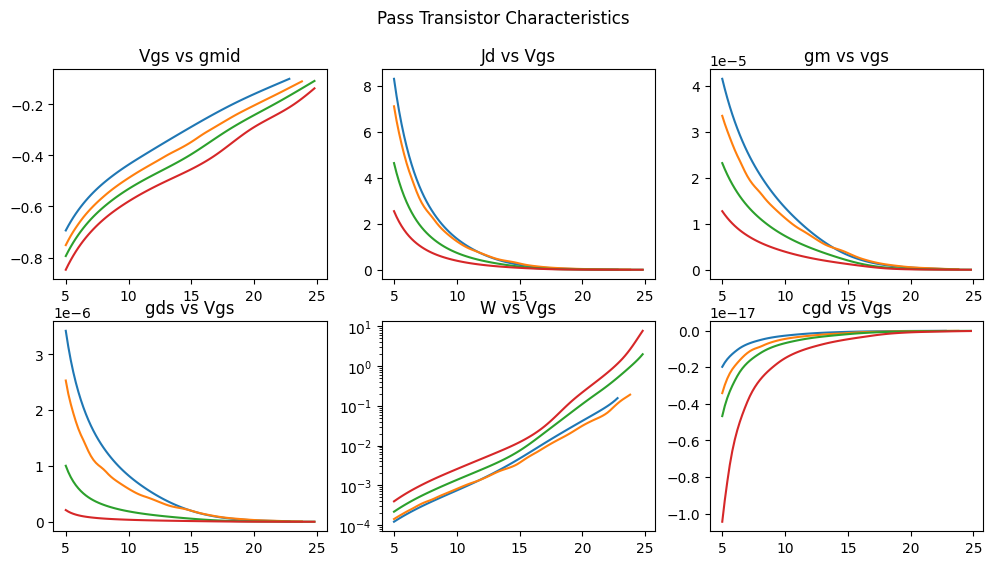

In [14]:
from gmid.mosplot import load_lookup_table
lookup_table = load_lookup_table("sky130A_LUT_lvt.npy")
## LDO exploration parameters (this vakues can be change as the user see fit)
lengths = [0.4e-06, 0.6e-06, 0.8e-06, 1.6e-06]      # Length exploration values.
gmid_sweep = np.arange(5,25,0.2)               # gm/id sweep for exploration.
pass_transistor = mna.pass_transistor_exploration(lookup_table, Vdd, Vreg, il, R1, R2, lengths, gmid_sweep, (-1.8, -0.1, 0.1))

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
fig.suptitle('Pass Transistor Characteristics')
for index, val in enumerate(lengths):
    axs[0, 0].plot(gmid_sweep, pass_transistor.vgs[index,:])
axs[0, 0].set_title('Vgs vs gmid')
for index, val in enumerate(lengths):
    axs[0, 1].plot(gmid_sweep, pass_transistor.Jd[index,:])
axs[0, 1].set_title('Jd vs Vgs')
for index, val in enumerate(lengths):
    axs[0, 2].plot(gmid_sweep, pass_transistor.gm[index,:])
axs[0, 2].set_title('gm vs vgs')
for index, val in enumerate(lengths):
    axs[1, 0].plot(gmid_sweep, pass_transistor.gds[index,:])
axs[1, 0].set_title('gds vs Vgs')
for index, val in enumerate(lengths):
    axs[1, 1].plot(gmid_sweep, pass_transistor.W[index,:])
axs[1, 1].set_title('W vs Vgs')
for index, val in enumerate(lengths):
    axs[1, 2].plot(gmid_sweep, pass_transistor.cgd[index,:])
axs[1, 2].set_title('cgd vs Vgs')
axs[1,1].set_yscale('log')

Matrix([[gds_3 + gm_3 + 1.45413e-5, -1.43875000000000e-5, -gm_3 - 1.538e-7, 0, 0, 0, 0, -1, 0, -gds_3], [-6.94970000000000e-6, 7.06622000000000e-6, 0, -1.35015200000000e-5, 0, 1.33850000000000e-5, 0, 0, 0, 0], [-7.59160000000000e-6, 7.43780000000000e-6, 3.22800000000000e-7, -1.53390000000000e-5, 1.51700000000000e-5, 0, 0, 0, 0, 0], [0, -1.16520000000000e-7, -1.69000000000000e-7, 2.93725200000000e-5, -1.51700000000000e-5, -1.33850000000000e-5, 1.58300000000000e-5, 0, 0, 0], [0, 0, 0, 0, 1.50000000000000e-5, 0, 0, 0, 0, -1.00000000000000e-5], [0, 0, 0, 0, 0, 0, 0, 0, -1, 0], [0, 0, 0, 0, 0, 0, 1.66970000000000e-5, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [-gds_3 - gm_3, 0, gm_3, 0, -1.00000000000000e-5, 0, 0, 0, 0, gds_3 + 1.0e-5]])


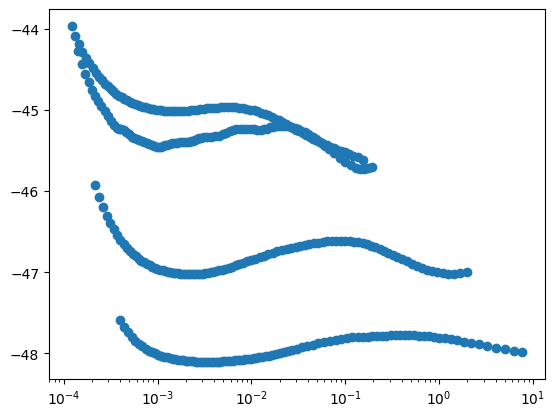

In [17]:
pm_restriction = 90
LG_restriction = 100

## Matrix G: DC (only pasives)
G = mna.get_G_matrix(M_1a, M_1b, M_2a, M_2b, M_4a, M_4b, R1, R2)
## Matrix B of the system (all the DC sources are shut down -> to get PSRR)
B = sym.Matrix([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])    #(v1, v2, v3, v4, v5, v6, v8, Ibias, vdd, vref, v9) 
print(G)

# 1. Lambdify the matrix so the parameters of the Pass Transistor can be replaced
gm_3 = sym.Symbol('gm_3')
gds_3 = sym.Symbol('gds_3')
PSRR_DC_lamb = sym.lambdify([gm_3, gds_3],(G.inv()*B)[9])
#print(PSRR_DC_lamb(np.multiply(M_3.gm, M_3.W*1e6), np.multiply(M_3.gds, M_3.W*1e6)))

# 2. Evaluation of the parameters into the transfer functioon matrix
## (IMPORTANt) The gm and gds must be scaled respect the W of the LUTs transistors. In other words, gm and gds must be mul by the PT W.
PSRR_DC = 20*np.log10((-1*PSRR_DC_lamb(np.multiply(pass_transistor.gm, pass_transistor.W*1e6), np.multiply(pass_transistor.gds, pass_transistor.W*1e6))))
## Second function to optimize, considering the PSRR as the first one.
L = sym.Symbol('L')
W = sym.Symbol('W')
Area = sym.lambdify([L, W], L+W)   # Total area of the pass transistor

lengths_reshaped = np.transpose(np.tile(lengths, (100,1)))
f_2 = Area(lengths_reshaped, pass_transistor.W)

f_1 = PSRR_DC

plt.scatter(f_2,f_1)
plt.xscale('log')

## 10. simulation

## 11. Resistance layout generation

## 12. Transistor layout generation

## 13. Floorplaning

## 14. Post layout simulation

## 15. Conclusion